# Exploratory data analysis

## Initial cohort

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import venn

from mousechd.utils.analyzer import (set_default_mplstyle,
                                     load_metadata,
                                     get_kingdom_df,
                                     plot_kingdom_venn)

set_default_mplstyle()

HOME = os.environ.get('HOME')
srcdir = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice"
datadir = f"{srcdir}/DATA/CTs"

terms = pd.read_csv(f'{datadir}/raw/Imagine/metadata/terminology_20201217.csv', sep=';')
terms["Kingdom"] = terms["Kingdom"].map({"Septal Defects": "Septal defects",
                                         "Atrial isomerism": "Atrial situs defects"
                                         }).fillna(terms["Kingdom"])
df = load_metadata(f'{datadir}/processed/Imagine/metadata_20210203.csv')

### Venn diagram of kingdoms

Figure 1b

In [5]:
kingdom_df = get_kingdom_df(terms, df)
kingdom_df.sum(axis=0)

Kingdom
Apex malposition                      20.0
Atrial situs defects                  27.0
Malposition of the great arteries     34.0
Normal heart                         101.0
Septal defects                        37.0
Ventricle malposition                 11.0
dtype: float64

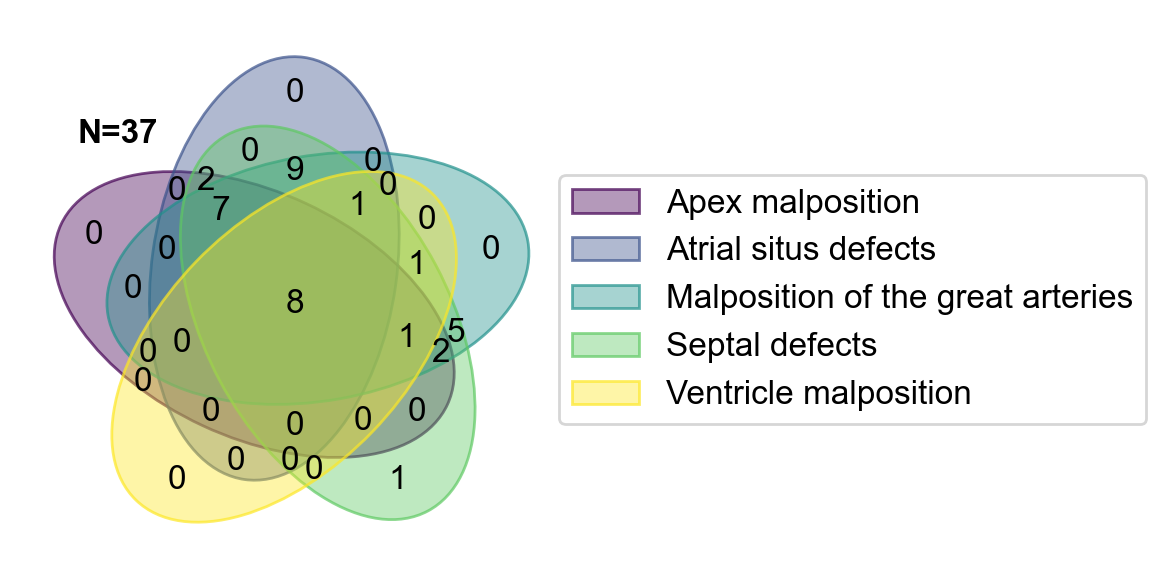

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plot_kingdom_venn(kingdom_df)

### Stages vs. CHD

## Figure 1c

In [7]:
df['Diagnosis'] = df['Normal heart'].map({1: 'Normal', 0: 'CHD'})

stage_diag = pd.crosstab(df.Stage, df.Diagnosis)
stage_diag.loc['TOTAL'] = stage_diag.sum(axis=0).to_list()
stage_diag.loc[:,'RATIO'] = (stage_diag.Normal/stage_diag.CHD).map('{:,.2f}'.format)
s = stage_diag.style.format()

# Style
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #0b5394; color: white;'
}

colors = {'selector': '.true', 'props': 'background-color: #0b5394; color: white; font-weight: bold;'}

cell_color = pd.DataFrame([['false', 'false', 'true'],
                           ['false', 'false', 'true'],
                           ['true', 'true', 'true']
                          ],
                          index=stage_diag.index,
                          columns=stage_diag.columns)

s.set_table_styles([index_names, headers, colors])
s.set_td_classes(cell_color)

Diagnosis,CHD,Normal,RATIO
Stage,,,
E18.5,15,41,2.73
P0,23,60,2.61
TOTAL,38,101,2.66


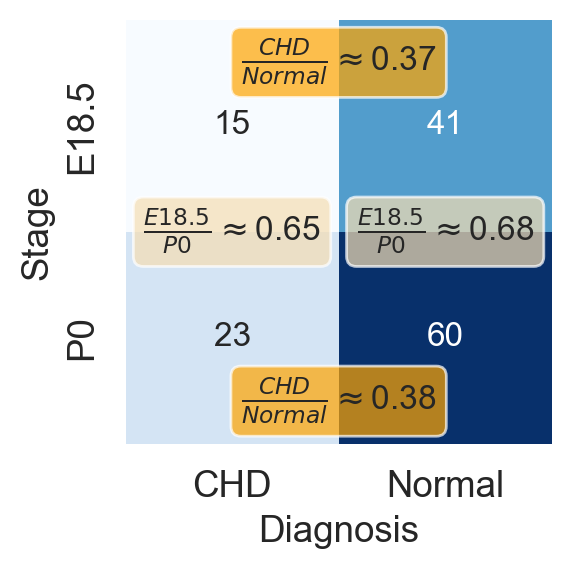

In [8]:
# Plot contingency matrix
from mousechd.utils.analyzer import plot_contingency
df['Diagnosis'] = df['Normal heart'].map({1: 'Normal', 0: 'CHD'})
plot_contingency(df, x="Diagnosis", y="Stage")

## Prospective and divergent cohorts

In [9]:
evaldir = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/PAPER/METADATA"

# Prospective cohort
pros_df = pd.read_csv(f"{evaldir}/prospective.csv")

# Divergent cohort
div_df = pd.read_csv(f"{evaldir}/divergent.csv")

In [10]:
# Table 2
pd.crosstab(pros_df.Stage, pros_df.label)

label,0,1
Stage,,
E18.5,6,12


In [11]:
pd.crosstab(div_df.Stage, div_df.label)

label,0,1
Stage,,
E17.5,32,8
E18.5,12,21
P0,7,0


In [12]:
div_df.label.value_counts()

label
0    51
1    29
Name: count, dtype: int64

### Disease Venn diagram
Supplementary Figure 4a

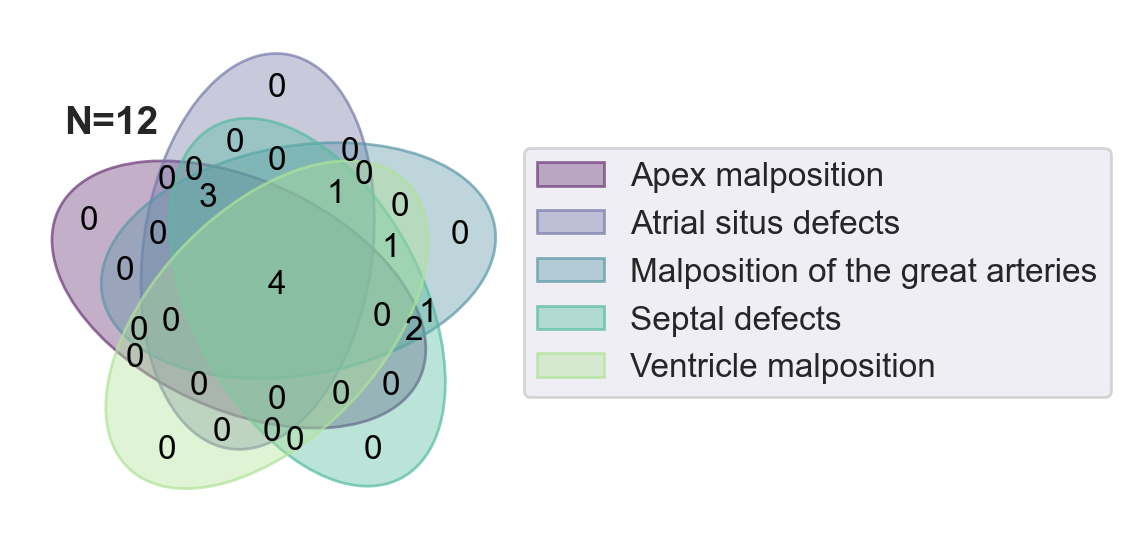

In [13]:
df = pros_df.copy()
colors = ["#6C3879", "#7879A9", "#5B97A7", "#55BCA0", "#AFE397"]

diseases = list(df.columns)[7:12]

subsets = {}
hearts = []

for d in diseases:
    subsets[d] = set(df[df[d]>0].heart_name)
    hearts += list(df[df[d]>0].heart_name)
    
venn.venn(subsets,
     fontsize=12,
     figsize=(3.25,4),
     legend_loc=(1,0.25),
     cmap=colors
    );
    
plt.text(0.15, 0.8,'N={}'.format(len(set(hearts))), 
         fontsize=14, 
         weight='bold',
         ha='center');

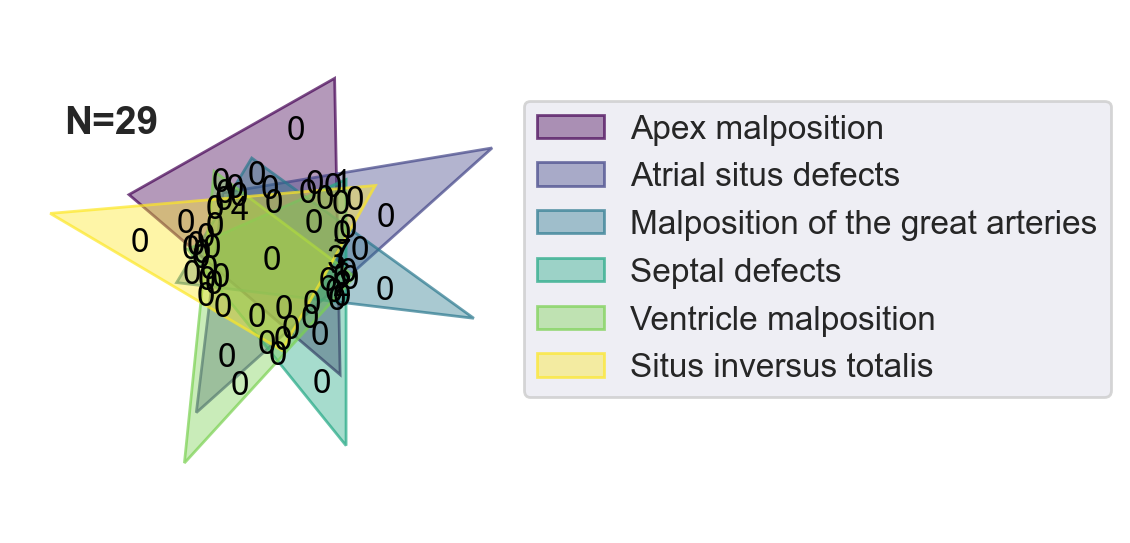

In [14]:
df = div_df.copy()
colors = ["#6C3879", "#7879A9", "#5B97A7", "#55BCA0", "#AFE397"]

diseases = list(df.columns)[6:12]

subsets = {}
hearts = []

for d in diseases:
    subsets[d] = set(df[df[d]>0].heart_name)
    hearts += list(df[df[d]>0].heart_name)
    
venn.venn(subsets,
     fontsize=12,
     figsize=(3.25,4),
     legend_loc=(1,0.25)
    );
    
plt.text(0.15, 0.8,'N={}'.format(len(set(hearts))), 
         fontsize=14, 
         weight='bold',
         ha='center');

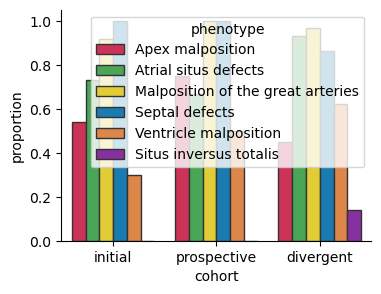

In [15]:
mpl.rcParams.update(mpl.rcParamsDefault)

diseases = list(div_df.columns)[6:12]
# colors = ["#6C3879", "#7879A9", "#5B97A7", "#55BCA0", "#AFE397", "#E5E33F"]
colors = ["#e6194bff", "#3cb44bff", "#ffe119ff", "#0082c8ff", "#f58231ff", "#911eb4ff"]

model_cohort = {}
pros_cohort = {}
div_cohort = {}

for d in diseases:
    try:
        model_cohort[d] = (kingdom_df[d]>0).sum()/37
    except:
        model_cohort[d] = 0
        
    try:
        pros_cohort[d] = (pros_df[d]>0).sum()/12
    except:
        pros_cohort[d] = 0
        
    div_cohort[d] = (div_df[d] > 0).sum()/29
    
numbers = {"initial": model_cohort,
           "prospective": pros_cohort,
           "divergent": div_cohort}
    
df = pd.DataFrame(columns=["phenotype", "dataset", "proportion"])
datasets = ["initial", "prospective", "divergent"]
for d in diseases:
    for dataset in datasets:
        df.loc[len(df), :] = [d, dataset, numbers[dataset][d]]
        
plt.figure(figsize=(4, 3))
ax = sns.barplot(x="dataset", y="proportion", hue="phenotype", data=df,
                 palette=colors,
                 edgecolor="0.2")
# plt.xticks(rotation=35, rotation_mode="anchor", ha="right");
plt.xlabel("cohort")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

df = pd.DataFrame(columns=diseases)
datasets = ["initial", "prospective", "divergent"]
for d in diseases:
    df.loc["initial", d] = model_cohort[d]*37
    df.loc["prospective", d] = pros_cohort[d]*12
    df.loc["divergent", d] = div_cohort[d]*29

plt.savefig(f"{srcdir}/PAPER/FIGURES/Sup04/components/barplot_3_cohorts.svg", bbox_inches="tight", dpi=100)
plt.show()

### Difference between initial cohort and prospective cohort

#### CHI2 -> FISHER

In [16]:
from scipy.stats import chi2_contingency,fisher_exact

model_comb = kingdom_df[diseases[:5]].astype(int).astype(str)
model_comb["Situs inversus totalis"] = "0"
model_comb["combination"] = model_comb[diseases].agg("-".join, axis=1)
model_comb = model_comb[model_comb["combination"] != "0-0-0-0-0-0"]

pros_comb = pros_df[diseases].astype(int).astype(str)
pros_comb["combination"] = pros_comb[diseases].agg("-".join, axis=1)
pros_comb = pros_comb[pros_comb["combination"] != "0-0-0-0-0-0"]

combs = model_comb["combination"].value_counts().index.tolist() + pros_comb["combination"].value_counts().index.tolist()
combs = list(set(combs))

df = pd.DataFrame(columns=combs)

for x in combs:
    try:
        df.loc["model", x] = model_comb["combination"].value_counts()[x]
    except:
        df.loc["model", x] = 0
    try:
        df.loc["prospective", x] = pros_comb["combination"].value_counts()[x]
    except:
        df.loc["prospective", x] = 0

df2 = np.asarray(df, dtype = np.int64)
fisher_exact(df2)
#chi2_contingency(df2)

SignificanceResult(statistic=np.float64(9.270814817115278e-05), pvalue=np.float64(0.4189))

### Difference between initial cohort and divergent cohort

#### CHI2 -> FISHER

In [17]:
model_comb = kingdom_df[diseases[:5]].astype(int).astype(str)
model_comb["Situs inversus totalis"] = "0"
model_comb["combination"] = model_comb[diseases].agg("-".join, axis=1)
model_comb = model_comb[model_comb["combination"] != "0-0-0-0-0-0"]

pros_comb = div_df[diseases].astype(int).astype(str)
pros_comb["combination"] = pros_comb[diseases].agg("-".join, axis=1)
pros_comb = pros_comb[pros_comb["combination"] != "0-0-0-0-0-0"]

combs = model_comb["combination"].value_counts().index.tolist() + pros_comb["combination"].value_counts().index.tolist()
combs = list(set(combs))

df = pd.DataFrame(columns=combs)

for x in combs:
    try:
        df.loc["model", x] = model_comb["combination"].value_counts()[x]
    except:
        df.loc["model", x] = 0
    try:
        df.loc["prospective", x] = pros_comb["combination"].value_counts()[x]
    except:
        df.loc["prospective", x] = 0


df2 = np.asarray(df, dtype = np.int64)
fisher_exact(df2)       
#chi2_contingency(df2)

SignificanceResult(statistic=np.float64(1.935456439607616e-08), pvalue=np.float64(0.0118))